In [1]:
using LinearAlgebra
using FFTW
using Random
using CairoMakie

In [2]:
# 2x2 Pauli X
function sigma_x()
    return [0 1; 1 0]
end
# 2x2 Pauli Y
function sigma_y()
    return [0 -im; im 0]
end
# 2x2 Pauli Z
function sigma_z()
    return [1 0; 0 -1]
end

sigma_z (generic function with 1 method)

In [3]:
function hamiltonian(hbar, vF, m, k)
    kx = k[1]
    ky = k[2]
    return hbar * vF * (kx * sigma_y() - ky * sigma_x()) + m * sigma_z()
end

hamiltonian (generic function with 1 method)

In [4]:
# get the eigenvector corresponding to the band-index (l) @ k = (kx, ky)
function eigen_vec(hbar, vF, m, k, l)
    ham = hamiltonian(hbar, vF, m, k)
    vecs = eigvecs(Hermitian(ham))
    return vecs[:, l]
end

eigen_vec (generic function with 1 method)

In [5]:
# compute the phase difference between wavefunction at (x1, y1) and (x2, y2)
function theta(x1, y1, x2, y2, hbar, vF, m, l)
    ev1 = eigen_vec(hbar, vF, m, [x1, y1], l)
    ev2 = eigen_vec(hbar, vF, m, [x2, y2], l)
    return dot(ev2, ev1) / abs(dot(ev2, ev1))
end

theta (generic function with 1 method)

In [6]:
# Berry flux through a plaquette with corners (x1, y1), (x2, y2), (x3, y3), (x4, y4)
function flux(x1, y1, x2, y2, x3, y3, x4, y4, hbar, vF, m, l)
    big_theta = theta(x2, y2, x1, y1, hbar, vF, m, l) *
        theta(x3, y3, x2, y2, hbar, vF, m, l) * theta(x4, y4, x3, y3, hbar, vF, m, l) * 
    theta(x1, y1, x4, y4, hbar, vF, m, l)
    # Numerical instability around flux = pi, so we always force it to choose +pi
    if abs(imag(big_theta)) < 10^(-12)
        return abs(angle(big_theta))
    else
        return angle(big_theta)
    end
end

flux (generic function with 1 method)

In [187]:
# Berry curvature
function berry_curvature(points, n, hbar, vF, m, l)
    berry_list = Vector{Float64}()
    avg_k_x = Vector{Float64}()
    avg_k_y = Vector{Float64}()
    for i in 1:(n - 1)
        for j in 1:(n - 1)
            x1 = points[i, j, 1]
            y1 = points[i, j, 2]
            
            x2 = points[i + 1, j, 1]
            y2 = points[i + 1, j, 2]
            
            x3 = points[i + 1, j + 1, 1]
            y3 = points[i + 1, j + 1, 2]
            
            x4 = points[i, j + 1, 1]
            y4 = points[i, j + 1, 2]
            
            x_avg = (x1 + x2 + x3 + x4)/4
            y_avg = (y1 + y2 + y3 + y4)/4
            
            append!(avg_k_x, x_avg)
            append!(avg_k_y, y_avg)
            curvature = flux(x1, y1, x2, y2, x3, y3, x4, y4, hbar, vF, m, l)
            append!(berry_list, curvature)
        end
    end
    return berry_list, avg_k_x, avg_k_y
end

berry_curvature (generic function with 2 methods)

In [12]:
# This generates a line of points in K-space
function make_line(x0, x1, n, y)
    x_vals = range(x0, x1, n)
    line_vals = Array{Float64}(undef, n, 2)
    for i in 1:n
        line_vals[i, :] = [x_vals[i], y]
    end
    return line_vals
end

# draw a square around k of dimensions radius x radius (with point-density n)
function k_zone(k, n, radius)
    kx = k[1]
    ky = k[2]
    grid = Array{Float64}(undef, n, n, 2)
    ky_pts = range(ky - radius/2, ky + radius/2, n)
    for i in 1:n
        grid[:, i, :] = make_line(kx - radius/2, kx + radius/2, n, ky_pts[i])
    end
    return grid
end

k_zone (generic function with 1 method)

In [182]:
# parameters
pd = 40
rad = 1
hbar = 1
vF = 0.1
m = 0.00001

1.0e-5

In [183]:
# explore a small region around K point
k_grid = k_zone([0, 0], pd, rad)

40×40×2 Array{Float64, 3}:
[:, :, 1] =
 -0.5       -0.5       -0.5       …  -0.5       -0.5       -0.5
 -0.474359  -0.474359  -0.474359     -0.474359  -0.474359  -0.474359
 -0.448718  -0.448718  -0.448718     -0.448718  -0.448718  -0.448718
 -0.423077  -0.423077  -0.423077     -0.423077  -0.423077  -0.423077
 -0.397436  -0.397436  -0.397436     -0.397436  -0.397436  -0.397436
 -0.371795  -0.371795  -0.371795  …  -0.371795  -0.371795  -0.371795
 -0.346154  -0.346154  -0.346154     -0.346154  -0.346154  -0.346154
 -0.320513  -0.320513  -0.320513     -0.320513  -0.320513  -0.320513
 -0.294872  -0.294872  -0.294872     -0.294872  -0.294872  -0.294872
 -0.269231  -0.269231  -0.269231     -0.269231  -0.269231  -0.269231
 -0.24359   -0.24359   -0.24359   …  -0.24359   -0.24359   -0.24359
 -0.217949  -0.217949  -0.217949     -0.217949  -0.217949  -0.217949
 -0.192308  -0.192308  -0.192308     -0.192308  -0.192308  -0.192308
  ⋮                               ⋱                        
  0.217949

In [184]:
# Get berry curvature for all bands
@time begin
    flux_list = Array{Float64}(undef, 2, (pd - 1)^2)
    kx_avg_list = Array{Float64}(undef, 2, (pd - 1)^2)
    ky_avg_list = Array{Float64}(undef, 2, (pd - 1)^2)
    for l in 1:2
        temp_flux, akx, aky = berry_curvature(k_grid, pd, hbar, vF, m, l)
        flux_list[l, :] = temp_flux
        kx_avg_list[l, :] = akx
        ky_avg_list[l, :] = aky
    end
    end

  0.040326 seconds (705.80 k allocations: 91.919 MiB)


In [185]:
# Compute the Chern numbers of each band
chern_numbers = Array{Float64}(undef, 2)
for l in 1:2
    chern_numbers[l] = sum(flux_list[l, :]) / (2 * pi)
end
@show chern_numbers

chern_numbers = [-0.4999099683698848, 0.4999099683698848]


2-element Vector{Float64}:
 -0.4999099683698848
  0.4999099683698848

The above result is what we're looking for. Introducing a Dirac mass gap means that upper and lower bands contribute $\pm \frac{1}{2}$ respectively to Chern number.

  0.290319 seconds (2.59 M allocations: 108.278 MiB)


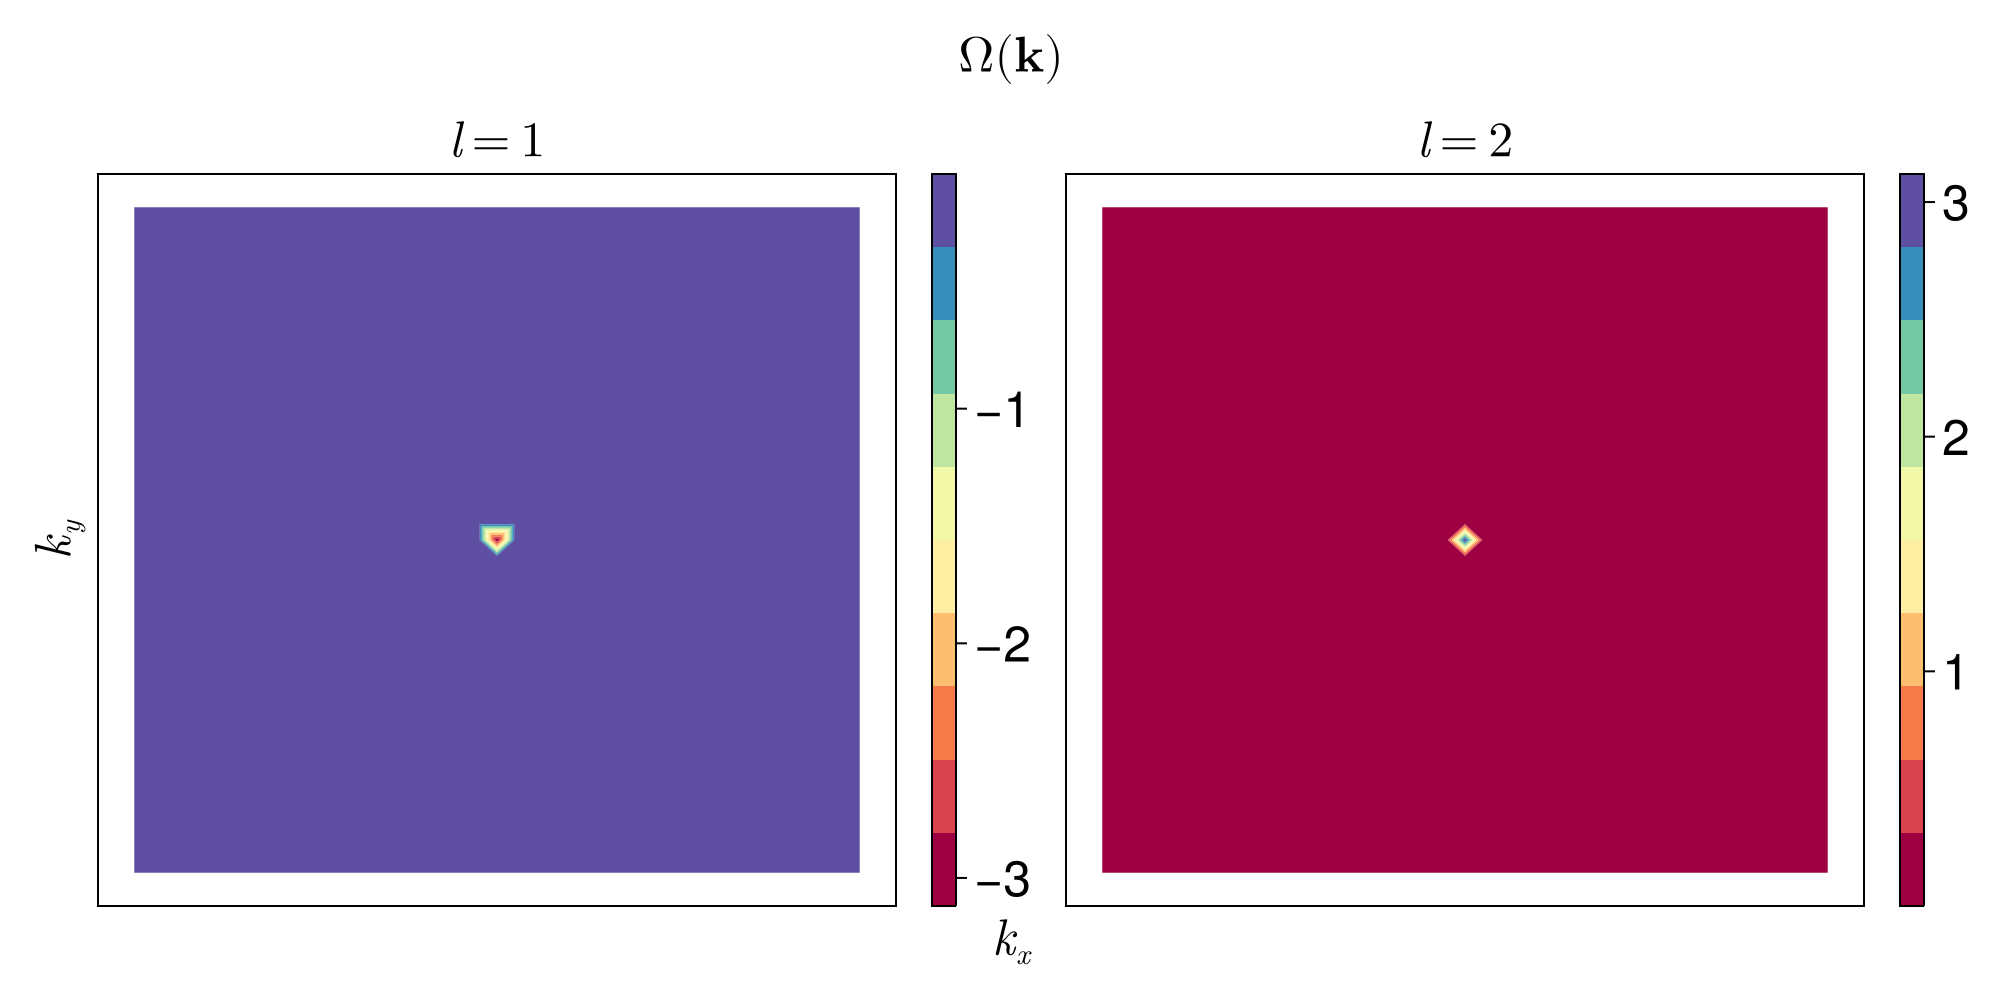

In [188]:
@time begin
    fig = Figure(size=(1000, 500), fontsize=25)
        
    t_string = L"l = 1"
    ax = Axis(fig[1, 1], title = t_string)
    hidedecorations!(ax)
    tricontourf!(ax, kx_avg_list[1, :], ky_avg_list[1, :], flux_list[1, :], colormap = :Spectral)

    X, ax, tr1 = tricontourf(kx_avg_list[1, :], ky_avg_list[1, :], flux_list[1, :], colormap = :Spectral)
    cb1 = Colorbar(fig[1, 2], tr1)
    
    t_string = L"l = 2"
    ax = Axis(fig[1, 3], title = t_string)
    hidedecorations!(ax)
    tricontourf!(ax, kx_avg_list[2, :], ky_avg_list[2, :], flux_list[2, :], colormap = :Spectral)
    
    X, ax, tr2 = tricontourf(kx_avg_list[2, :], ky_avg_list[2, :], flux_list[2, :], colormap = :Spectral)
    cb2 = Colorbar(fig[1, 4], tr2)


    ax = Axis(fig[:, :], xlabel = L"k_x", ylabel = L"k_y", title = L"\Omega (\textbf{k})", titlegap = 45)
    hidedecorations!(ax, label = false)
    hidespines!(ax)
    fig
        
    end